In [2]:
import numpy as np
import pandas as pd
import h5py
import math

%matplotlib inline
import matplotlib.pyplot as plt

# import pygad as pg
import vpfits

### Load galaxy spectrum and perform region detection

In [3]:
vpfit = vpfits.VPfit()

In [4]:
#gals = [231,3,347,280,41,0,141,398]
gals = [3]
tag = 'gal'
fulltag = 'galaxies'
los_num = 0
line = 'H1215'
for i in range(len(gals)):
    gal = gals[los_num]
    with h5py.File('../cgm/spectra_pygad/spectra_m25n256z125_{}_H1215_FG11/spectrum_m25n256z125_H1215_FG11_{}{}.h5'.format(fulltag, tag, gal), 'r') as hf:
        wl_all = np.array(hf.get('wavelength'))
        tau_all = np.array(hf.get('tau'))
        flux_all = np.array(hf.get('flux'))
        noise_all = np.array(hf.get('noise'))
        dens_col_all = np.array(hf.get('density_col'))
        dens_phys_all = np.array(hf.get('density_phys'))
        vel_all = np.array(hf.get('velocity'))
        regions = vpfits.compute_detection_regions(wl_all, flux_all, noise_all)
        

region_arrays = []
region_pixels = []
for region in regions:
    start = np.where(wl_all == region[0])[0][0]
    end = np.where(wl_all == region[1])[0][0]
    region_pixels.append([start, end])
    region_arrays.append([wl_all[start:end], flux_all[start:end], tau_all[start:end]])

IOError: Unable to open file (Unable to open file: name = '../cgm/spectra_pygad/spectra_m25n256z125_galaxies_h1215_fg11/spectrum_m25n256z125_h1215_fg11_gal3.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

### Perform voigt profile fit with VAMP on each region

Initialising Voigt profile components.
n:  2
Initialising Voigt profile components.
Fit 1 BIC:  -160.392442513 , Fit 2 BIC:  -115.389572234
BIC Ratio:  1.39000812125
n (final):  1
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 40.2 sec
Took: 0:00:40.201364  to finish.


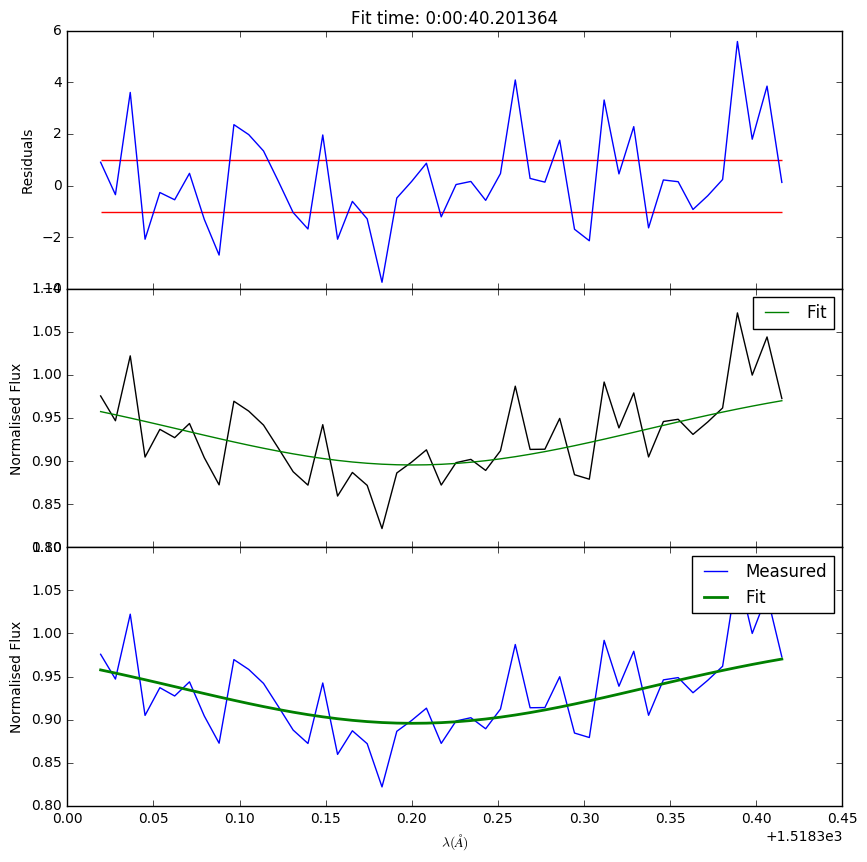

Initialising Voigt profile components.
n:  2
Initialising Voigt profile components.
Fit 1 BIC:  -1905.02379555 , Fit 2 BIC:  -1927.59252508
BIC Ratio:  0.988291752931
n (final):  1
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 42.7 sec
Took: 0:00:42.730464  to finish.


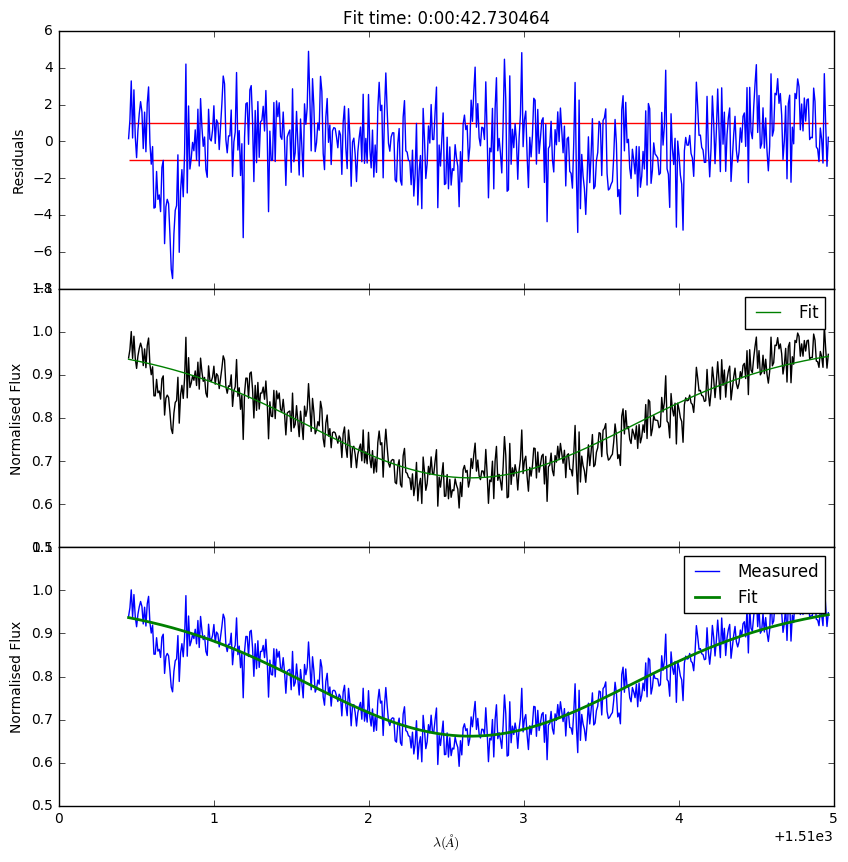

Initialising Voigt profile components.
n:  2
Initialising Voigt profile components.
Fit 1 BIC:  -230.008846475 , Fit 2 BIC:  -54.8796701416
BIC Ratio:  4.19114848689
n (final):  1
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 43.8 sec
Took: 0:00:43.814495  to finish.


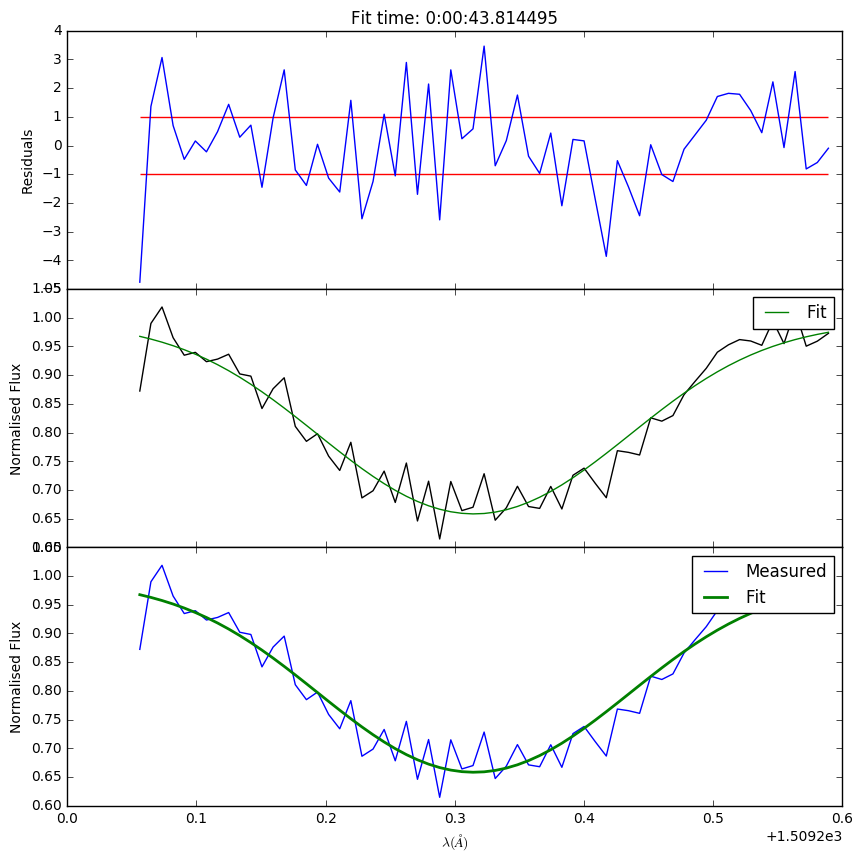

In [4]:
fits = []
flux_arrs = []
wl_arrs = []
tau_arrs = []

voigt = True

for i in range(len(region_arrays)):
    wavelengths = region_arrays[i][0][::-1]
    fluxes = region_arrays[i][1][::-1]
    taus = region_arrays[i][2][::-1]
    
    r = 0
    n = 1
    
    vpfit_2 = vpfits.VPfit()
    vpfit_2.initialise_model(wavelengths, fluxes, n, voigt=voigt)
    vpfit_2.map_estimate()

    while r < 0.95:

        n += 1
        print "n: ", n

        vpfit_1 = vpfit_2

        vpfit_2 = vpfits.VPfit()
        vpfit_2.initialise_model(wavelengths, fluxes, n, voigt=voigt)
        vpfit_2.map_estimate()
        
        print "Fit 1 BIC: ", vpfit_1.MAP.BIC, ", Fit 2 BIC: ", vpfit_2.MAP.BIC
        print "BIC Ratio: ", vpfit_1.MAP.BIC / vpfit_2.MAP.BIC
        
        r = vpfit_1.MAP.BIC / vpfit_2.MAP.BIC
    
    n -= 1
    print "n (final): ", n
    vpfit_1.mcmc_fit()
    
    fits.append(vpfit_1)
    flux_arrs.append(fluxes)
    wl_arrs.append(wavelengths)
    tau_arrs.append(taus)
    
    start = region_pixels[i][0]
    end = region_pixels[i][1]
    
    vpfit_1.plot(wavelengths, fluxes, n=n, start_pix=start, end_pix=end)

### Calculate column densities from Voigt profile

In [23]:
import vpfits
from scipy.integrate import simps

# Look at the nth fit from those above. Will use the first profile from the selected fit
n = 1

# So you have to know the line in advance to know f? Or should find centroid of 
# profile, find closest line and then look up f? Here, assume H1215 bc we know it is
lines = pg.analysis.absorption_spectra.lines
ldict = lines[line]

f = float(ldict['f'])

fit = fits[n]
fluxes = flux_arrs[n]
lambdas = wl_arrs[n]
taus = np.array(tau_arrs[n])

voigt_prof = np.array(fit.estimated_profiles[0].value)
dx = lambdas[1] - lambdas[0]
print("Integral of VP:",simps(voigt_prof, dx=dx)) # Is normalized to integrate to 1? No

amplitude = float(fit.estimated_variables[0]['amplitude']) # What is this amplitude value?? =~7, not actually max
centroid = float(fit.estimated_variables[0]['centroid'] / 1.0e10)  # Angstrom to m

m_e = 9.10938356e-31  # kg
q_e = 1.60217662e-19  # Coulombs
c = 3.0e8  # m/s
b = float(fit.estimated_variables[0]['G']) / 1.0e10  # Doppler width of line, Angstrom to m 
#b = b / (2 * np.sqrt(2 * np.log(2)))  # FWHM to width - don't think need this, think doppler width is FWHM not sigma

### HOW TO GET TAUCONST?? ###
tauconst = max(voigt_prof) 
# Or could calculate tauconst this way?? But then not constant!! 
# x = np.array((lambdas/1.0e10 - centroid)/b)
# tauconst = np.array(voigt_prof) / np.exp(-x*x)
# or....
# tau0 = taus/voigt_prof # Eqn 19 trident paper


# For trident, use eqns 19 and 20 from trident paper: https://arxiv.org/abs/1612.03935
N_tri = (tauconst * m_e * c) / (math.pi * q_e**2 * f * centroid) # Eqn 20, trident paper
N_tri = pg.UnitArr(N_tri, 'm**-2').in_units_of('cm**-2')

# For AutoVP calc, see email - assume b and centroid in Angstrom, all others SI, and N in cm^-2
N_autovp = (tauconst * m_e * c**2 * (b*1.0e10)) / (1.0e5 * f * math.sqrt(math.pi) * q_e**2 * (centroid*1.0e10)**2) 

# Calculate column density from tau the way pygad does (from what I can tell - differs by 4*pi*epsilon0 / dv)
epsilon0 = 8.85418782e-12
dv = (vel_all[1]-vel_all[0])*1000.0  # km/s to m/s
N_pg = (taus * 4.0 * epsilon0 * m_e * c) / (q_e**2 * f * centroid) * dv # Something is not right here...

#Splice actual column density array to same wavelength range
ix_end = np.where(wl_all==min(lambdas))[0][0]
ix_start = np.where(wl_all==max(lambdas))[0][0]
wl_actual = wl_all[ix_start:ix_end]
dens_col_actual = dens_col_all[ix_start:ix_end]

print("------------------------")
print("Column Densities, cm**-2")
print("------------------------")
print("Actual column density: {:.3e}".format(sum(dens_col_actual)))
print('Trident column density: {:.3e}'.format(float(N_tri)))
print('AutoVP column density: {:.3e}'.format(float(N_autovp)))
print('Pygad column density: {:.3e}'.format(sum(N_pg)))


('Integral of VP:', 1.0588020412265169)
------------------------
Column Densities, cm**-2
------------------------
Actual column density: 1.554e+14
Trident column density: 2.223e+18
AutoVP column density: 1.399e+13
Pygad column density: 1.250e+18


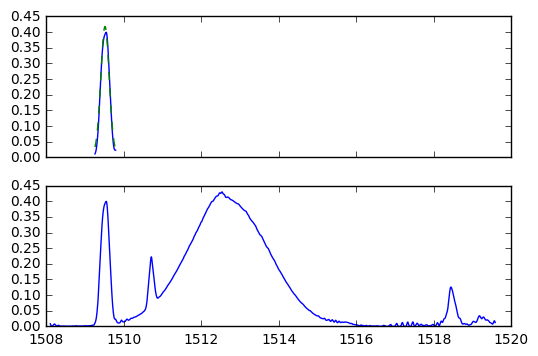

In [6]:
fig, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(lambdas, taus)
axarr[0].plot(lambdas, voigt_prof, linestyle='--')
axarr[1].plot(wl_all, tau_all)

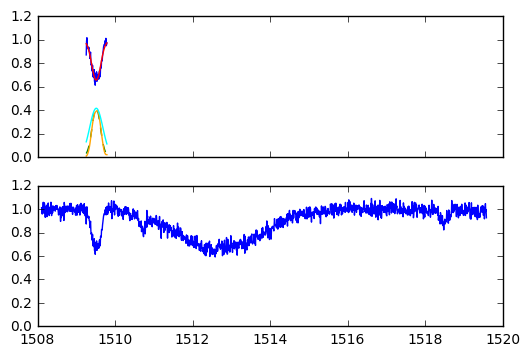

In [22]:
fig, axarr = plt.subplots(2, sharex=True, sharey=True)
v = np.array(fit.estimated_profiles[0].value)
axarr[0].plot(lambdas, fluxes)
axarr[0].plot(lambdas, v, color='green', linestyle='--')
axarr[0].plot(lambdas, np.exp(-v), color='red')
axarr[0].plot(lambdas, taus, color='orange')

x = np.array((lambdas/1.0e10 - centroid)/b)
axarr[0].plot(lambdas, max(v)*np.exp(-x*x), color='cyan')

axarr[1].plot(wl_all, flux_all)

In [ ]:
print(fit.total.value[0])
print((fit.estimated_profiles[0].value))